In [2]:
import psycopg2
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from numpy import random

from sklearn.preprocessing import StandardScaler

import os
os.chdir('/home/rafalb/work/molecules/moleculesStatic')

### Database connection

In [47]:
connection = psycopg2.connect(user = "chembl",
                              password = "chembl",
                              host = "127.0.0.1",
                              port = "5432",
                              database = "chembl_25")
cursor = connection.cursor()

### Types of activities

In [48]:
cursor.execute('select min(AC.standard_type) AS TYPE, count(AC.standard_type) AS COUNT from ACTIVITIES AC GROUP BY standard_type')
activities = pd.DataFrame(cursor.fetchall(), columns = ['type', 'count'])

In [49]:
activities[activities['count'] > 100000]

,type,count
110,AC50,156790
145,Activity,839702
1694,EC50,394406
2115,GI50,2579793
2401,IC50,2049897
2561,Inhibition,959104
2868,Ki,687703
3878,MIC,544741
4762,Potency,4473542
5798,Tissue Severity Score,128999


### Main query

In [51]:
columns = ['molregno', 'canonical_smiles', 'activity_id', 
           'standard_value', 'standard_units', 'standard_flag', 'standard_type', 'activity_comment',
           'alogp', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ros_violations', 'molecular_species', 'full_mwt', 'aromatic_rings', 'heavy_atoms', 'qed_weighted']

cursor.execute("select CS.molregno, \
               CS.canonical_smiles, \
               AC.activity_id, \
               AC.standard_value, \
               AC.standard_units, \
               AC.standard_flag, \
               AC.standard_type, \
               AC.activity_comment, \
               CP.ALOGP, \
               CP.HBA, \
               CP.HBD, \
               CP.PSA, \
               CP.RTB, \
               CP.RO3_PASS, \
               CP.NUM_RO5_VIOLATIONS, \
               CP.MOLECULAR_SPECIES, \
               CP.FULL_MWT, \
               CP.AROMATIC_RINGS, \
               CP.HEAVY_ATOMS, \
               CP.QED_WEIGHTED \
               from COMPOUND_STRUCTURES CS \
               inner join ACTIVITIES AC on CS.molregno = AC.molregno \
               inner join COMPOUND_PROPERTIES CP on CS.molregno = CP.MOLREGNO \
               and (AC.standard_type = 'IC50' or AC.standard_type = 'GI50' or AC.standard_type = 'Potency') \
               and (AC.standard_value IS NOT NULL)")
molData = pd.DataFrame(cursor.fetchall(), columns = columns)
connection.close()

InterfaceError: cursor already closed

In [71]:
molData.shape

(8744913, 22)

In [0]:
molData.head(10).iloc[1,:]

### Data conversion

In [0]:
floatDescriptors = ['standard_value', 'alogp', 'psa', 'full_mwt', 'qed_weighted']
for moldesc in floatDescriptors:
    molData[moldesc] = molData[moldesc].astype(float)

intDescriptors = ['molregno']#, 'hba', 'hbd', 'rtb', 'aromatic_rings', 'heavy_atoms']
for moldesc in intDescriptors:
    molData[moldesc] = molData[moldesc].astype(int)

### What units do we have?

In [0]:
# mess in units
molData.groupby('standard_units').agg('count')

In [0]:
# take only the entries expressed in nM
molData = molData[molData['standard_units']=='nM'].reset_index()
molData.groupby('standard_units').agg('count')

In [0]:
molData.head(5)

### Data aggregation

In [0]:
aggFunctions = {
                'molregno': ['min', 'count'], 'canonical_smiles': 'min',
                'standard_value': ['min', 'max'],
                'standard_type': 'min',
                'alogp': ['min', 'max'],
                'hba': ['min', 'max'],
                'hbd': ['min', 'max'],
                'psa': ['min', 'max'],
                'rtb': ['min', 'max'],
                'ro3_pass': 'min',
                'num_ros_violations': 'min',
                'molecular_species': 'min',
                'full_mwt': ['min', 'max'],
                'aromatic_rings': 'min',
                'heavy_atoms': 'min',
                'qed_weighted': ['min', 'max']
                }
grouped = molData.groupby('molregno')
molDataGrouped = grouped.agg(aggFunctions).reset_index()

In [70]:
molDataGrouped.head(5)

molregno                                             canonical_smiles  \
           min count                                                min   
0       10  10     2  C1CCCCCNc2cc[n+](Cc3cccc(c3)c4cccc(C[n+]5ccc(N...   
1       23  23    64                Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
2       24  24     1                 I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
3       25  25     1                 O=C1O\C(=C\C#C)\CCC1c2cccc3ccccc23   
4       26  26     1                 I\C=C/1\CCC(C(=O)O1)c2cccc3ccccc23   

  standard_value          standard_type alogp        hba  ...  rtb ro3_pass  \
             min      max           min   min   max  min  ...  max      min   
0          110.0    110.0          IC50  9.29  9.29  2.0  ...  0.0        N   
1            3.2  73078.0          IC50  4.50  4.50  2.0  ...  1.0        N   
2           30.0     30.0          IC50  4.54  4.54  2.0  ...  1.0        N   
3           95.0     95.0          IC50  3.78  3.78  2.0  ...  1.0        N   
4          190.0    190.0          IC50  4.54  4.54  2.0  ...  1.0        N   

  num_ros_violations molecular_species full_mwt         aromatic_rings  \
                 min               min      min     max            min   
0                2.0           NEUTRAL   606.86  606.86            6.0   
1                0.0               NaN   317.18  317.18            2.0   
2                0.0               NaN   364.18  364.18            2.0   
3                0.0               NaN   262.31  262.31            2.0   
4                0.0               NaN   364.18  364.18            2.0   

  heavy_atoms qed_weighted        
          min          min   max  
0        46.0         0.17  0.17  
1        19.0         0.72  0.72  
2        19.0         0.55  0.55  
3        20.0         0.58  0.58  
4        19.0         0.55  0.55  

[5 rows x 26 columns]

### Activity type distribution

In [0]:
# THE GI50/IC50 distribution
molDataGrouped['standard_type'].groupby('min').agg({'min': ['count']})

### Pickling of the data

In [3]:
import pickle
pcklFile = 'molDataGrouped.pckl'

In [67]:
with open(pcklFile, 'wb') as file:
    pickle.dump(molDataGrouped, file)

In [119]:
with open(pcklFile, 'rb') as file:
    molDataGrouped = pickle.load(file)

In [86]:
molDataGrouped.columns

MultiIndex(levels=[['molregno', 'canonical_smiles', 'standard_value', 'standard_type', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ros_violations', 'molecular_species', 'full_mwt', 'aromatic_rings', 'heavy_atoms', 'qed_weighted'], ['count', 'max', 'min', '']],
           codes=[[0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 11, 12, 12, 13, 14, 15, 15], [3, 2, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1]])

In [82]:
molDataGrouped.loc[:, ['canonical_smiles', 'min']].values

In [83]:
molDataGrouped.head(10)

molregno                                             canonical_smiles  \
           min count                                                min   
0       10  10     2  C1CCCCCNc2cc[n+](Cc3cccc(c3)c4cccc(C[n+]5ccc(N...   
1       23  23    64                Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
2       24  24     1                 I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
3       25  25     1                 O=C1O\C(=C\C#C)\CCC1c2cccc3ccccc23   
4       26  26     1                 I\C=C/1\CCC(C(=O)O1)c2cccc3ccccc23   
5       31  31     1  COc1cc2nc(nc(N)c2cc1OC)N3CCN(CC3)C(=O)C4CC4c5c...   
6       33  33     1  COc1cc2nc(nc(N)c2cc1OC)N3CCN(CC3)S(=O)(=O)c4cccs4   
7       38  38     2  C1CCCCCNc2cc[n+](Cc3ccc(cc3)c4ccc(C[n+]5ccc(NC...   
8       39  39     3  Nc1cc[n+](Cc2cccc(c2)c3cccc(C[n+]4ccc(N)c5cccc...   
9       46  46     3  Nc1cc[n+](Cc2ccc(CCc3ccc(C[n+]4ccc(N)c5ccccc45...   

  standard_value             standard_type alogp        hba  ...  rtb  \
             min         max           min   min   max  min  ...  max   
0       110.0000    110.0000          IC50  9.29  9.29  2.0  ...  0.0   
1         3.2000  73078.0000          IC50  4.50  4.50  2.0  ...  1.0   
2        30.0000     30.0000          IC50  4.54  4.54  2.0  ...  1.0   
3        95.0000     95.0000          IC50  3.78  3.78  2.0  ...  1.0   
4       190.0000    190.0000          IC50  4.54  4.54  2.0  ...  1.0   
5         0.5129      0.5129          IC50  2.68  2.68  7.0  ...  5.0   
6        33.8800     33.8800          IC50  1.80  1.80  9.0  ...  5.0   
7       170.0000    170.0000          IC50  9.29  9.29  2.0  ...  0.0   
8       290.0000    290.0000          IC50  5.50  5.50  2.0  ...  5.0   
9       410.0000    410.0000          IC50  5.61  5.61  2.0  ...  7.0   

  ro3_pass num_ros_violations molecular_species full_mwt          \
       min                min               min      min     max   
0        N                2.0           NEUTRAL   606.86  606.86   
1        N                0.0               NaN   317.18  317.18   
2        N                0.0               NaN   364.18  364.18   
3        N                0.0               NaN   262.31  262.31   
4        N                0.0               NaN   364.18  364.18   
5        N                0.0           NEUTRAL   433.51  433.51   
6        N                0.0           NEUTRAL   435.53  435.53   
7        N                2.0           NEUTRAL   606.86  606.86   
8        N                1.0           NEUTRAL   468.60  468.60   
9        N                1.0           NEUTRAL   496.66  496.66   

  aromatic_rings heavy_atoms qed_weighted        
             min         min          min   max  
0            6.0        46.0         0.17  0.17  
1            2.0        19.0         0.72  0.72  
2            2.0        19.0         0.55  0.55  
3            2.0        20.0         0.58  0.58  
4            2.0        19.0         0.55  0.55  
5            3.0        32.0         0.66  0.66  
6            3.0        29.0         0.65  0.65  
7            6.0        46.0         0.17  0.17  
8            6.0        36.0         0.33  0.33  
9            6.0        38.0         0.28  0.28  

[10 rows x 26 columns]

### Smiles analysis

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw

In [129]:
def provideMoleculeStatistics(smiles):
    #print(smiles)
    mol = Chem.MolFromSmiles(smiles)
    
    newSmiles = Chem.MolToSmiles(mol, canonical = True, isomericSmiles = False)
    negativeCharged = sum([ item.GetFormalCharge() if item.GetFormalCharge() < 0 else 0 for item in mol.GetAtoms() ])
    positiveCharged = sum([ item.GetFormalCharge() if item.GetFormalCharge() > 0 else 0 for item in mol.GetAtoms() ])
    #anyCharged = any([item1 or item2 for item1, item2 in zip(negativelyCharged, positivelyCharged)])
    
    elementsList = list(set([atom.GetSymbol() for atom in mol.GetAtoms()]))
    numberOfRings = mol.GetRingInfo().NumRings()
    
    return(newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings)


In [130]:
import codecs
encodeToUTF8 = False
def canonicalizeSmilesAndProvideDescriptor(smiles):
    #rdkitMol = Chem.MolFromSmiles(molecule)
    #Chem.SanitizeMol(rdkitMol)
    try:
        #newSmiles = Chem.MolToSmiles(rdkitMol, canonical = True, isomericSmiles = False)
        newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings = provideMoleculeStatistics(smiles)
        #smilesDescription = checkVariousSmilesProperties(newSmiles)
        #elementsSet = provideElementsList(newSmiles)        
    except:
        newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings = (None, None, None, None, None)
        # There was a trouble in catching the ArgumentError exception (originatefd most likely in Boost.Python 
        # therefore any exceptio s caught here)
        print('Exception!!! :', smiles)
        
    if (encodeToUTF8):
        return((codecs.encode(newSmiles, 'utf-8'), negativeCharged, positiveCharged, elementsList, numberOfRings))
    else:
        return((newSmiles, negativeCharged, positiveCharged, elementsList, numberOfRings))

In [122]:
print(pd.__version__)

0.24.2


In [116]:
def printRow(row):
    print('in')
    print(row)
    mol = Chem.MolFromSmiles(row)

In [117]:

molDataGrouped.loc[:2, ('canonical_smiles', 'min')].apply(printRow)
 #.apply(canonicalizeSmilesAndProvideDescriptor)

in
C1CCCCCNc2cc[n+](Cc3cccc(c3)c4cccc(C[n+]5ccc(NCCCC1)c6ccccc56)c4)c7ccccc27
in
Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23
in
I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23


0    None
1    None
2    None
Name: (canonical_smiles, min), dtype: object

In [131]:
len(molDataGrouped)

1129745

In [132]:
sourceColumn = ('canonical_smiles', 'min')
nTotal = len(molDataGrouped)
nStart = 0
nSize = 10000
nBatch = np.ceil((nTotal - nStart)/nSize).astype(int)
for iii in range(nBatch):
    iBeg = nStart + iii * nSize
    if (iii == nBatch - 1):
        iEnd = nTotal
    else:
        iEnd = nStart + (iii + 1) * nSize
    print(iii)
    result = molDataGrouped.loc[iBeg:iEnd, sourceColumn].apply(canonicalizeSmilesAndProvideDescriptor)
    molDataGrouped.loc[iBeg:iEnd, 'canonicalSmiles'] = [item[0] for item in result]
    molDataGrouped.loc[iBeg:iEnd, 'negativeCharged'] = [item[1] for item in result]
    molDataGrouped.loc[iBeg:iEnd, 'positiveCharged'] = [item[2] for item in result]
    molDataGrouped.loc[iBeg:iEnd, 'elementsSet'] = [item[3] for item in result]
    molDataGrouped.loc[iBeg:iEnd, 'numberOfRings'] = [item[4] for item in result]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
Exception!!! : c1ccc2c(c1)[i+]c3ccccc23
14
15
16
17
Exception!!! : [Cl-].c1ccc2c(c1)[i+]c3ccccc23
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
Exception!!! : Clp1(Cl)np(Cl)(Cl)np2(NNP(=O)(NN2)Oc3ccccc3)n1
73
74
Exception!!! : Clp1(Cl)np(Cl)(Cl)np2(NNP(=S)(NN2)Oc3ccccc3)n1
75
Exception!!! : N1c2ccccc2p3(c4ccccc14)c5ccccc5nc6ccccc36
76
Exception!!! : S=P1(NNp2(NN1)np(np(n2)(N3CC3)N4CC4)(N5CC5)N6CC6)Oc7ccccc7
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


In [133]:
molDataGrouped.head(4)

molregno                                             canonical_smiles  \
           min count                                                min   
0       10  10     2  C1CCCCCNc2cc[n+](Cc3cccc(c3)c4cccc(C[n+]5ccc(N...   
1       23  23    64                Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
2       24  24     1                 I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
3       25  25     1                 O=C1O\C(=C\C#C)\CCC1c2cccc3ccccc23   

  standard_value          standard_type alogp        hba  ... full_mwt  \
             min      max           min   min   max  min  ...      max   
0          110.0    110.0          IC50  9.29  9.29  2.0  ...   606.86   
1            3.2  73078.0          IC50  4.50  4.50  2.0  ...   317.18   
2           30.0     30.0          IC50  4.54  4.54  2.0  ...   364.18   
3           95.0     95.0          IC50  3.78  3.78  2.0  ...   262.31   

  aromatic_rings heavy_atoms qed_weighted        \
             min         min          min   max   
0            6.0        46.0         0.17  0.17   
1            2.0        19.0         0.72  0.72   
2            2.0        19.0         0.55  0.55   
3            2.0        20.0         0.58  0.58   

                                     canonicalSmiles negativeCharged  \
                                                                       
0  c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...               0   
1                     O=C1OC(=CBr)CCC1c1cccc2ccccc12               0   
2                      O=C1OC(=CI)CCC1c1cccc2ccccc12               0   
3                  C#CC=C1CCC(c2cccc3ccccc23)C(=O)O1               0   

  positiveCharged elementsSet numberOfRings  
                                             
0               2      [N, C]             7  
1               0  [Br, O, C]             3  
2               0   [I, O, C]             3  
3               0      [O, C]             3  

[4 rows x 31 columns]

In [144]:
molDataGrouped[molDataGrouped['elementsSet'] == None]

Empty DataFrame
Columns: [(molregno, ), (molregno, min), (molregno, count), (canonical_smiles, min), (standard_value, min), (standard_value, max), (standard_type, min), (alogp, min), (alogp, max), (hba, min), (hba, max), (hbd, min), (hbd, max), (psa, min), (psa, max), (rtb, min), (rtb, max), (ro3_pass, min), (num_ros_violations, min), (molecular_species, min), (full_mwt, min), (full_mwt, max), (aromatic_rings, min), (heavy_atoms, min), (qed_weighted, min), (qed_weighted, max), (canonicalSmiles, ), (negativeCharged, ), (positiveCharged, ), (elementsSet, ), (numberOfRings, )]
Index: []

[0 rows x 31 columns]

In [134]:
with open('molDataGroupedDesc.pckl', 'wb') as file:
    pickle.dump(molDataGrouped, file)

In [1]:
with open('molDataGroupedDesc.pckl', 'rb') as file:
    molDataGrouped = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'molDataGroupedDesc.pckl'

In [3]:
molDataGrouped = molDataGrouped[~molDataGrouped['elementsSet'].isnull()]

In [4]:
organicChemistryList = ['B', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
organicChemistrySet = set(organicChemistryList)

In [5]:
testSet = set(['N', 'C', 'Cl'])
testSet < organicChemistrySet

True

In [6]:
molDataGrouped['organicChemistryElementsOnly'] = molDataGrouped['elementsSet'].apply(lambda x: set(x) < organicChemistrySet)

In [7]:
molDataGrouped.groupby('organicChemistryElementsOnly').count()

molregno                   canonical_smiles  \
                                           min    count              min   
organicChemistryElementsOnly                                               
False                            7048     7048     7048             7048   
True                          1122691  1122691  1122691          1122691   

                             standard_value          standard_type    alogp  \
                                        min      max           min      min   
organicChemistryElementsOnly                                                  
False                                  7048     7048          7048     4198   
True                                1122691  1122691       1122691  1109144   

                                           hba  ... full_mwt aromatic_rings  \
                                  max      min  ...      max            min   
organicChemistryElementsOnly                    ...                           
False                            4198     4198  ...     7048           4198   
True                          1109144  1109144  ...  1122691        1109144   

                             heavy_atoms qed_weighted           \
                                     min          min      max   
organicChemistryElementsOnly                                     
False                               4198         4198     4198   
True                             1109144      1109144  1109144   

                             canonicalSmiles negativeCharged positiveCharged  \
                                                                               
organicChemistryElementsOnly                                                   
False                                   7048            7048            7048   
True                                 1122691         1122691         1122691   

                             elementsSet numberOfRings  
                                                        
organicChemistryElementsOnly                            
False                               7048          7048  
True                             1122691       1122691  

[2 rows x 31 columns]

In [8]:
molDataGrouped['canonicalSmilesLength'] = molDataGrouped['canonicalSmiles'].apply(lambda x: len(x))

(array([8.83140e+04, 8.06722e+05, 1.98516e+05, 2.13500e+04, 6.51400e+03,
        2.31300e+03, 1.69100e+03, 8.86000e+02, 6.39000e+02, 2.90000e+02,
        8.48000e+02, 2.79000e+02, 1.28000e+02, 1.72000e+02, 1.51000e+02,
        1.83000e+02, 1.07000e+02, 3.76000e+02, 9.40000e+01, 7.70000e+01,
        3.10000e+01, 1.00000e+01, 1.10000e+01, 3.00000e+00, 3.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 3.00000e+00, 2.00000e+00,
        0.00000e+00, 6.00000e+00, 1.00000e+00, 1.00000e+00, 4.00000e+00,
        0.00000e+00, 3.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   2.  ,   30.58,   59.16,   87.74,  116.32,  144.9 ,  173.48,
         202.06,  230.64,  259.22,  287.8 ,  316.38,  344.96,  373.54,
         402.12,  430.7 ,  459.28,  487.86,  516.44,  545.02,  573.6 ,
         602.18,  630.76,  659.34,  687.92,  716.5 ,  7

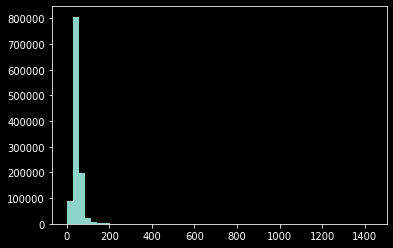

In [9]:
plt.hist(molDataGrouped['canonicalSmilesLength'], bins = 50)

In [10]:
limitSmilesLength = 100
molDataGroupedChosen = molDataGrouped[(molDataGrouped['canonicalSmilesLength'] < limitSmilesLength) & \
                      (molDataGrouped['negativeCharged'] == 0) & \
                      (molDataGrouped['positiveCharged'] == 0) & \
                      (molDataGrouped['numberOfRings'] <= 5) & \
                      (molDataGrouped['organicChemistryElementsOnly'])].reset_index()

In [11]:
replacementDict = {'Br': 'G', 'Cl': 'U', '[nH]': 'W'}
molDataGroupedChosen['encodedSmiles'] = molDataGroupedChosen['canonicalSmiles'].replace(replacementDict, regex=True)

In [12]:
molDataGroupedChosen.head(5)

index molregno                                             canonical_smiles  \
                 min count                                                min   
0     1       23  23    64                Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
1     2       24  24     1                 I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
2     3       25  25     1                 O=C1O\C(=C\C#C)\CCC1c2cccc3ccccc23   
3     4       26  26     1                 I\C=C/1\CCC(C(=O)O1)c2cccc3ccccc23   
4     5       31  31     1  COc1cc2nc(nc(N)c2cc1OC)N3CCN(CC3)C(=O)C4CC4c5c...   

  standard_value             standard_type alogp        ... qed_weighted  \
             min         max           min   min   max  ...          min   
0         3.2000  73078.0000          IC50  4.50  4.50  ...         0.72   
1        30.0000     30.0000          IC50  4.54  4.54  ...         0.55   
2        95.0000     95.0000          IC50  3.78  3.78  ...         0.58   
3       190.0000    190.0000          IC50  4.54  4.54  ...         0.55   
4         0.5129      0.5129          IC50  2.68  2.68  ...         0.66   

                                           canonicalSmiles negativeCharged  \
    max                                                                      
0  0.72                     O=C1OC(=CBr)CCC1c1cccc2ccccc12               0   
1  0.55                      O=C1OC(=CI)CCC1c1cccc2ccccc12               0   
2  0.58                  C#CC=C1CCC(c2cccc3ccccc23)C(=O)O1               0   
3  0.55                      O=C1OC(=CI)CCC1c1cccc2ccccc12               0   
4  0.66  COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...               0   

  positiveCharged elementsSet numberOfRings organicChemistryElementsOnly  \
                                                                           
0               0  [Br, O, C]             3                         True   
1               0   [I, O, C]             3                         True   
2               0      [O, C]             3                         True   
3               0   [I, O, C]             3                         True   
4               0   [N, O, C]             5                         True   

  canonicalSmilesLength                                      encodedSmiles  
                                                                            
0                    30                      O=C1OC(=CG)CCC1c1cccc2ccccc12  
1                    29                      O=C1OC(=CI)CCC1c1cccc2ccccc12  
2                    33                  C#CC=C1CCC(c2cccc3ccccc23)C(=O)O1  
3                    29                      O=C1OC(=CI)CCC1c1cccc2ccccc12  
4                    51  COc1cc2Wc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)Wc(N)c2...  

[5 rows x 35 columns]

In [13]:
molDataGroupedChosen.shape

(972746, 35)

In [14]:
# molDataGroupedFinal_100.pckl: smiles length < 100
with open('molDataGroupedFinal_100.pckl', 'wb') as file:
    pickle.dump(molDataGroupedChosen, file)

In [3]:
with open('molDataGroupedFinal.pckl', 'rb') as file:
    molDataGroupedChosen = pickle.load(file)


In [4]:
molDataGroupedChosen.head()

index molregno                                             canonical_smiles  \
                 min count                                                min   
0     1       23  23    64                Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
1     2       24  24     1                 I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23   
2     3       25  25     1                 O=C1O\C(=C\C#C)\CCC1c2cccc3ccccc23   
3     4       26  26     1                 I\C=C/1\CCC(C(=O)O1)c2cccc3ccccc23   
4     5       31  31     1  COc1cc2nc(nc(N)c2cc1OC)N3CCN(CC3)C(=O)C4CC4c5c...   

  standard_value             standard_type alogp        ... qed_weighted  \
             min         max           min   min   max  ...          min   
0         3.2000  73078.0000          IC50  4.50  4.50  ...         0.72   
1        30.0000     30.0000          IC50  4.54  4.54  ...         0.55   
2        95.0000     95.0000          IC50  3.78  3.78  ...         0.58   
3       190.0000    190.0000          IC50  4.54  4.54  ...         0.55   
4         0.5129      0.5129          IC50  2.68  2.68  ...         0.66   

                                           canonicalSmiles negativeCharged  \
    max                                                                      
0  0.72                     O=C1OC(=CBr)CCC1c1cccc2ccccc12               0   
1  0.55                      O=C1OC(=CI)CCC1c1cccc2ccccc12               0   
2  0.58                  C#CC=C1CCC(c2cccc3ccccc23)C(=O)O1               0   
3  0.55                      O=C1OC(=CI)CCC1c1cccc2ccccc12               0   
4  0.66  COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...               0   

  positiveCharged elementsSet numberOfRings organicChemistryElementsOnly  \
                                                                           
0               0  [Br, O, C]             3                         True   
1               0   [I, O, C]             3                         True   
2               0      [O, C]             3                         True   
3               0   [I, O, C]             3                         True   
4               0   [N, O, C]             5                         True   

  canonicalSmilesLength                                      encodedSmiles  
                                                                            
0                    30                      O=C1OC(=CG)CCC1c1cccc2ccccc12  
1                    29                      O=C1OC(=CI)CCC1c1cccc2ccccc12  
2                    33                  C#CC=C1CCC(c2cccc3ccccc23)C(=O)O1  
3                    29                      O=C1OC(=CI)CCC1c1cccc2ccccc12  
4                    51  COc1cc2Wc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)Wc(N)c2...  

[5 rows x 35 columns]

In [5]:
nSmilesCodes = 50000
mask = random.randint(0, molDataGroupedChosen.shape[0], size=nSmilesCodes)

In [6]:
staticFeatures = pd.DataFrame()
toBeAveraged = ['standard_value', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'full_mwt', 'qed_weighted']
for quantity in toBeAveraged:
    staticFeatures.loc[:, quantity] = (molDataGroupedChosen.loc[mask, (quantity, 'min')] + molDataGroupedChosen.loc[mask, (quantity, 'max')])/2
    staticFeatures.loc[:, quantity].astype(float)
toBeTaken = ['aromatic_rings', 'heavy_atoms']
for quantity in toBeTaken:
    staticFeatures.loc[:, quantity] = molDataGroupedChosen.loc[mask, (quantity, 'min')]
    staticFeatures.loc[:, quantity].astype(float)
staticFeatures.loc[:, 'number_of_rings'] = molDataGroupedChosen.loc[mask, 'numberOfRings'].astype(float)
staticFeatures.loc[:, 'number_of_rings'] = staticFeatures.loc[:, 'number_of_rings'].astype(float)
print(staticFeatures.head(2))
#staticFeatures = staticFeatures.values

standard_value  alogp  hba  hbd    psa  rtb full_mwt qed_weighted  \
563757        40366.15   4.14  6.0  1.0  85.97  7.0   368.39         0.50   
531880         4700.00   4.06  3.0  1.0  44.95  2.0   329.20         0.89   

        aromatic_rings  heavy_atoms  number_of_rings  
563757             3.0         27.0              3.0  
531880             2.0         20.0              3.0  


In [7]:
staticFeatures['full_mwt'] = staticFeatures.full_mwt.astype(float)
staticFeatures['qed_weighted'] = staticFeatures.qed_weighted.astype(float)
staticFeatures['aromatic_rings'] = staticFeatures.qed_weighted.astype(float)


In [8]:
thres = 100000
staticFeatures[staticFeatures['standard_value'] < thres].shape[0] / staticFeatures['standard_value'].shape[0]

0.94226

In [9]:
staticFeatures = staticFeatures[staticFeatures['standard_value'] < thres]

In [10]:
staticFeatures.shape

(47113, 11)

standard_value
alogp
hba
hbd
psa
rtb
full_mwt
qed_weighted
aromatic_rings
heavy_atoms
number_of_rings


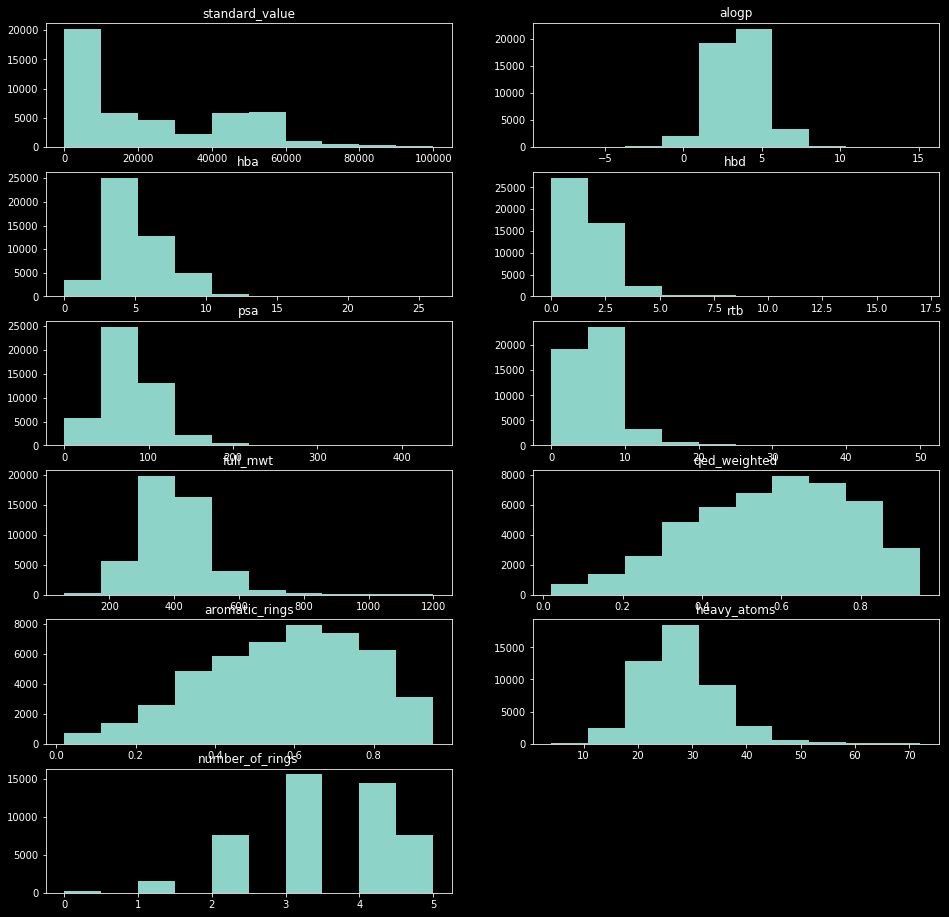

In [11]:
allDescriptors = ['standard_value', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'full_mwt', 'qed_weighted', 'aromatic_rings', 'heavy_atoms', 'number_of_rings']
#allDescriptors = ['standard_value']
#quantity = 'alogp'
plotIdx = 1
nRows = np.ceil(len(allDescriptors) / 2)
fig = plt.figure(figsize=(16, 16)) 
for quantity in allDescriptors:
    print(quantity)
    plt.subplot(nRows, 2, plotIdx)
    plt.hist(staticFeatures[~staticFeatures[quantity].isnull()][quantity], bins = 10)
    plt.title(quantity)
    plotIdx += 1


## Dynamic features

In [12]:
smilesCodes = molDataGroupedChosen.loc[staticFeatures.index, 'encodedSmiles']
smilesCodes

563757          CCOC(=O)c1cc2cc(CC(=O)c3ccc(OCC)cc3O)ccc2o1
531880                   Cc1cccc(C2=NN=C(c3ccc(G)cc3)C2)c1O
951541    Cc1cc(N)Wc(C)c1CNC(=O)c1cWW(Cc2ccc3ccc(U)cc3W2)c1
256989                     O=S(=O)(Nc1cc(U)ccW1)c1ccc(U)cc1
976552          Cc1Wsc(-c2WWc3W2CCN(C(=O)c2cccc(F)c2)C3C)W1
                                ...                        
937267                           CCNC(=S)Nc1cc(N2CCCC2)WcW1
305543        COC(=O)c1sc2cccc(F)c2c1S(=O)(=O)NC(C)c1ccccc1
207891    CC(C)=CCC1CC23CC(CC=C(C)C)C(C)(C)C(CC=C(C)C)(C...
897963    COc1cc(-c2WWc3W2CCCC3(c2ccc(F)c(F)c2)C(C)(C)O)...
247851                 O=c1[WW]c(COCCc2cccc(F)c2)Wc2Wcccc12
Name: encodedSmiles, Length: 47113, dtype: object

In [13]:
maxlen = -1
for code in smilesCodes:
    if len(code) > maxlen:
        maxlen = len(code)
maxlen

149

In [14]:
minlen = 1e6
for code in smilesCodes:
    if len(code) < minlen:
        minlen = len(code)
minlen

5

In [15]:
def pad_smile(string, max_len, padding='right'):
    if len(string) <= max_len:
        if padding == 'right':
            return string + " " * (max_len - len(string))
        elif padding == 'left':
            return " " * (max_len - len(string)) + string
        elif padding == 'none':
            return string


In [16]:
smilesCodes = smilesCodes.apply(lambda x: pad_smile(x, max_len=maxlen, padding='right'))

In [17]:
chars = sorted(list(set(smilesCodes.str.cat(sep=''))))
print('total chars:', len(chars))
char2indices = dict((c, i) for i, c in enumerate(chars))
indices2char = dict((i, c) for i, c in enumerate(chars))

total chars: 28


In [18]:
dynamicFeatures = np.zeros((len(smilesCodes), maxlen, len(chars)), dtype=np.float)
dynamicFeatures.shape

(47113, 149, 28)

In [19]:
for codeidx, code in enumerate(smilesCodes):
    for charidx, char in enumerate(code):
        dynamicFeatures[codeidx, charidx, char2indices[char]] = 1

(array([    0.,     0.,     0.,     0.,     0., 47113.,     0.,     0.,
            0.,     0.]),
 array([148.5, 148.6, 148.7, 148.8, 148.9, 149. , 149.1, 149.2, 149.3,
        149.4, 149.5]),
 <a list of 10 Patch objects>)

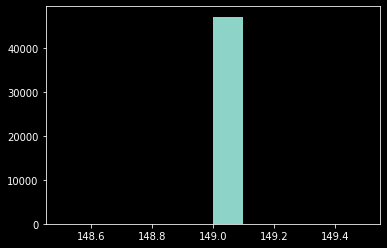

In [20]:
sums = []
for idx in range(dynamicFeatures.shape[0]):
    sums.append(np.sum(dynamicFeatures[idx, :, :]))
plt.hist(sums)

In [21]:
staticChosen = ['alogp', 'full_mwt']
scaler = StandardScaler()
scaler.fit(staticFeatures[staticChosen])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
staticFeaturesStandard = scaler.transform(staticFeatures[staticChosen])

## Autoencoder architecture

In [23]:
from keras.layers import LSTM, TimeDistributed, concatenate, Input, Dense, RepeatVector, Lambda
from keras.models import Model
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
import keras.backend as K
from keras.utils import plot_model
from keras import losses
import numpy.random as rnd

Using TensorFlow backend.


In [24]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [25]:
def prepare_model(static, dynamic, k, window, charsetLen, lr, lossFunction, showArch):
    input_dynamic = Input(shape=(window, charsetLen), name="input_dynamic")
    input_static = Input(shape=(static,), name="input_static")
    latent = Dense(k[0], activation=relu)(input_static)
    dense_h = Dense(k[0])(latent)
    dense_c = Dense(k[0])(latent)
    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic,
                                                                                        initial_state=[dense_h,
                                                                                                       dense_c])

    for x in k[1:-1]:
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])
    x = k[-1]
    concat_h = concatenate([dense_h, state_h])
    dense_h = Dense(x)(concat_h)
    concat_c = concatenate([dense_c, state_c])
    dense_c = Dense(x)(concat_c)
    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer, initial_state=[dense_h, dense_c])
    concat = concatenate([lstm_layer, latent])

    # autoencoder
    z_mean = Dense(x, name='z_mean')(concat)
    z_log_var = Dense(x, name='z_log_var')(concat)
    
    
    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])
    
    
    
    state_h = Dense(k[-2], activation=relu)(z)
    dense_h = Dense(k[-2], activation=relu)(z)
    state_c = Dense(k[-2], activation=relu)(z)
    dense_c = Dense(k[-2], activation=relu)(z)
    lstm_layer = RepeatVector(window)(z)

    for x in np.flip(k[:-1]):
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    result_series = LSTM(charsetLen, return_sequences=True, activation='softmax')(lstm_layer)
    concat = concatenate([state_h, state_c])
    #result_sigmoid = Dense(static-3, activation=sigmoid)(concat)
    result_relu = Dense(static, activation=sigmoid)(concat)

    #model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_relu])
    optimizer = RMSprop(lr=lr)
    model.compile(optimizer=optimizer, loss=lossFunction, metrics=['binary_crossentropy', 'mean_absolute_error'])
    if (showArch):
        print(model.summary())
    return model

In [26]:
def fit(staticFeatures, dynamicFeatures, model, step=1):
    #dynamic_data = np.empty((0, window, 1), np.float)
    #helper = []
    #for d in dynamic:
    #    new_data = rolling_window(d, window, step)
    #    helper.append(len(new_data))
    #    dynamic_data = np.append(dynamic_data, new_data, axis=0)
    #print(len(helper))
    #static_data = np.repeat(static, helper, axis=0)
    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = 'autoencoder.h5'
    checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, monitor='val_loss')

    size = int(staticFeatures.shape[0] * 0.9)
    training_dynamic, training_static = dynamicFeatures[order[:size]], staticFeatures[order[:size]]
    testing_dynamic, testing_static = dynamicFeatures[order[size:]], staticFeatures[order[size:]]
    print(training_dynamic.shape, training_static.shape)
    print(testing_dynamic.shape, testing_static.shape)
    model.fit([training_dynamic, training_static], 
              [training_dynamic, training_static],
                   epochs=10,
                   batch_size=64,
                   callbacks=[early_stopping, checkpoint],
                   validation_data=([testing_dynamic, testing_static], 
                                    [testing_dynamic, testing_static]))

In [29]:
lr = 0.001
model = prepare_model(staticFeaturesStandard.shape[1], 1, [64,64], dynamicFeatures.shape[1], dynamicFeatures.shape[2], lr, ['binary_crossentropy', 'mean_absolute_error'], True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_static (InputLayer)       (None, 2)            0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           192         input_static[0][0]               
__________________________________________________________________________________________________
input_dynamic (InputLayer)      (None, 149, 28)      0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 64)           4160        dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (

In [30]:
fit(staticFeaturesStandard, dynamicFeatures, model)

(42401, 149, 28) (42401, 2)
(4712, 149, 28) (4712, 2)
Train on 42401 samples, validate on 4712 samples
Epoch 1/10


In [74]:
dynamicFeatures[0,:,:].reshape(-1, dynamicFeatures.shape[1], dynamicFeatures.shape[2])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]])

In [72]:
staticFeaturesStandard[0,:].reshape(-1, staticFeaturesStandard.shape[1]).shape

(1, 11)

In [1]:
prediction = model.predict([dynamicFeatures[0,:,:].reshape(-1, dynamicFeatures.shape[1], dynamicFeatures.shape[2]), staticFeaturesStandard[0,:].reshape(-1, staticFeaturesStandard.shape[1]) ])

NameError: name 'model' is not defined

In [83]:
prediction[0]

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [34]:
import SmilesEnumerator

SyntaxError: invalid syntax (SmilesEnumerator.py, line 221)